<a href="https://colab.research.google.com/github/blacurly/Natural-Language-Processing-Cognitive-Computing/blob/main/Hands%20on%20Exercise%20for%20Regex%20and%20Text%20Normalization%20on%20Food%20Inspection%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Hands on Exercise for Regex, Text Normalization on Food Inspection

##### Import Necessary Package & Load Data

In [ ]:
import pandas as pd
import sys
import re
import matplotlib.pyplot as plt
import nltk
import string

from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer

#### 1) Select only the records corresponding to failed inspections (see the "results" column).

In [ ]:
data = data[data["Results"].str.contains("Fail", na=False)].copy()
data.head(2)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,1068208,CHINA COURT RESTAURANT,CHINA COURT RESTAURANT,2141795.0,Restaurant,Risk 1 (High),1146 N MILWAUKEE AVE,CHICAGO,IL,60642.0,03/14/2012,License Re-Inspection,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.902462,-87.665306,"(41.902462266949634, -87.66530609467256)"
5,1072529,GRESHAM ELEMENTARY SCHOOL,GRESHAM ELEMENTARY SCHOOL,23451.0,School,Risk 1 (High),8524 S Green (832W),CHICAGO,IL,60620.0,09/05/2013,Canvass,Fail,12. HAND WASHING FACILITIES: WITH SOAP AND SAN...,41.738913,-87.645062,"(41.73891334027122, -87.6450616939937)"


#### 2) Use regular expressions to extract the regulation description and inspector comments from the "violations" columns.
Every record representations a restaurant inspection. The "violations" column contains "|"-separated violations encountered during inspection (there can be more than one violation during a given inspection). Each violation generally consists of a regulation code, regulation description, and comments describing how the regulation was violated.

In [ ]:
data['Violations'][10]

'6. HANDS WASHED AND CLEANED, GOOD HYGIENIC PRACTICES; NO BARE HAND CONTACT WITH READY-TO-EAT FOODS. - Comments: EMPLOYEES WERE OBSERVED NOT WASHING HANDS IN BETWEEN HANDLING DIRTY TOWELS AND SHELL EGGS AND READY TO EAT FOOD AND OPENING COOLER DOORS, THE COOLER HANDLES HAVE A 1/4" BUILDUP OF FOOD ON THEM.  OBSERVE GOOD HANDWASHING PRACTICES AND MINIMIZE BAERE HAND CONTACT WITH READY TO EAT FOOD.  WASH HANDS WHEN THEY ARE DIRTY AND IN BETWEEN JOBS. | 18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS - Comments: 5 LIVE COCKROACHES WERE FOUND UNDER THE KITCHEN SINK BACKSPLASH, REMOVE ALL EVIDENCE OF PESTS. | 31. CLEAN MULTI-USE UTENSILS AND SINGLE SERVICE ARTICLES PROPERLY STORED: NO REUSE OF SINGLE SERVICE ARTICLES - Comments: THE KNIVES ARE STORED IN AN UNSANITARY HOLDER WITH FOOD ON THE BLADES, THE CUTTING BOARDS ARE STAINED AND UNSANITARY.  CLEAN, RINSE AND SANITIZE THE KNIVES AND BOARDS. | 33. FO

In [ ]:
#violation_pattern = re.compile(r"(?:^|\s)(\d+)\.\s*([^–-]+?)\s*[–-]+\s*Comments:\s*(.*?)(?=\|\s*\d+\.|$)")
violation_pattern = re.compile(
    r"(\d+)\.\s*(.+?)\s*[-–]+\s*Comments:\s*(.*?)(?=\s*\|\s*\d+\.|$)",
    re.DOTALL | re.IGNORECASE
)

def extract_violations(violation_str):
    return [
        (code.strip(), description.strip(), comment.strip())
        for code, description, comment in violation_pattern.findall(str(violation_str))
    ]

data['Violation_Parsed'] = data['Violations'].apply(extract_violations)
data[['Violations', 'Violation_Parsed']]



,Violations,Violation_Parsed
0,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,"[(18, NO EVIDENCE OF RODENT OR INSECT OUTER OP..."
5,12. HAND WASHING FACILITIES: WITH SOAP AND SAN...,"[(12, HAND WASHING FACILITIES: WITH SOAP AND S..."
6,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,"[(18, NO EVIDENCE OF RODENT OR INSECT OUTER OP..."
7,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,"[(2, FACILITIES TO MAINTAIN PROPER TEMPERATURE..."
8,"1. SOURCE SOUND CONDITION, NO SPOILAGE, FOODS ...","[(1, SOURCE SOUND CONDITION, NO SPOILAGE, FOOD..."
...,...,...
288915,37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER ...,"[(37, FOOD PROPERLY LABELED; ORIGINAL CONTAINE..."
288924,37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER ...,"[(37, FOOD PROPERLY LABELED; ORIGINAL CONTAINE..."
288925,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...","[(38, INSECTS, RODENTS, & ANIMALS NOT PRESENT,..."
288929,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...","[(3, MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL..."


#### 3) Count how many times each regulation description occurred in the table and visualize the top 10 most frequent regulation descriptions.

In [ ]:
code_desc_counts = Counter(
    (code, desc)
    for violations in data['Violation_Parsed']
    for code, desc, _ in violations
)

count_regulation = pd.DataFrame(code_desc_counts.items(), columns=['Code_Desc', 'Count'])
count_regulation[['Code', 'Description']] = pd.DataFrame(count_regulation['Code_Desc'].tolist(), index=count_regulation.index)
count_regulation = count_regulation.drop(columns='Code_Desc')
top10_regulation = count_regulation.sort_values(by='Count', ascending=False).head(10)
top10_regulation

,Count,Code,Description
47,23197,55,"PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN"
4,19341,34,"FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD RE..."
10,18223,35,"WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTE..."
16,16423,33,FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS C...
0,16420,18,NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS...
18,15504,38,VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQ...
1,14991,32,FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DE...
39,12947,38,"INSECTS, RODENTS, & ANIMALS NOT PRESENT"
37,12254,10,ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED A...
2,10650,41,"PREMISES MAINTAINED FREE OF LITTER, UNNECESSAR..."


<ipython-input-29-5a1de7ad11e9>:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


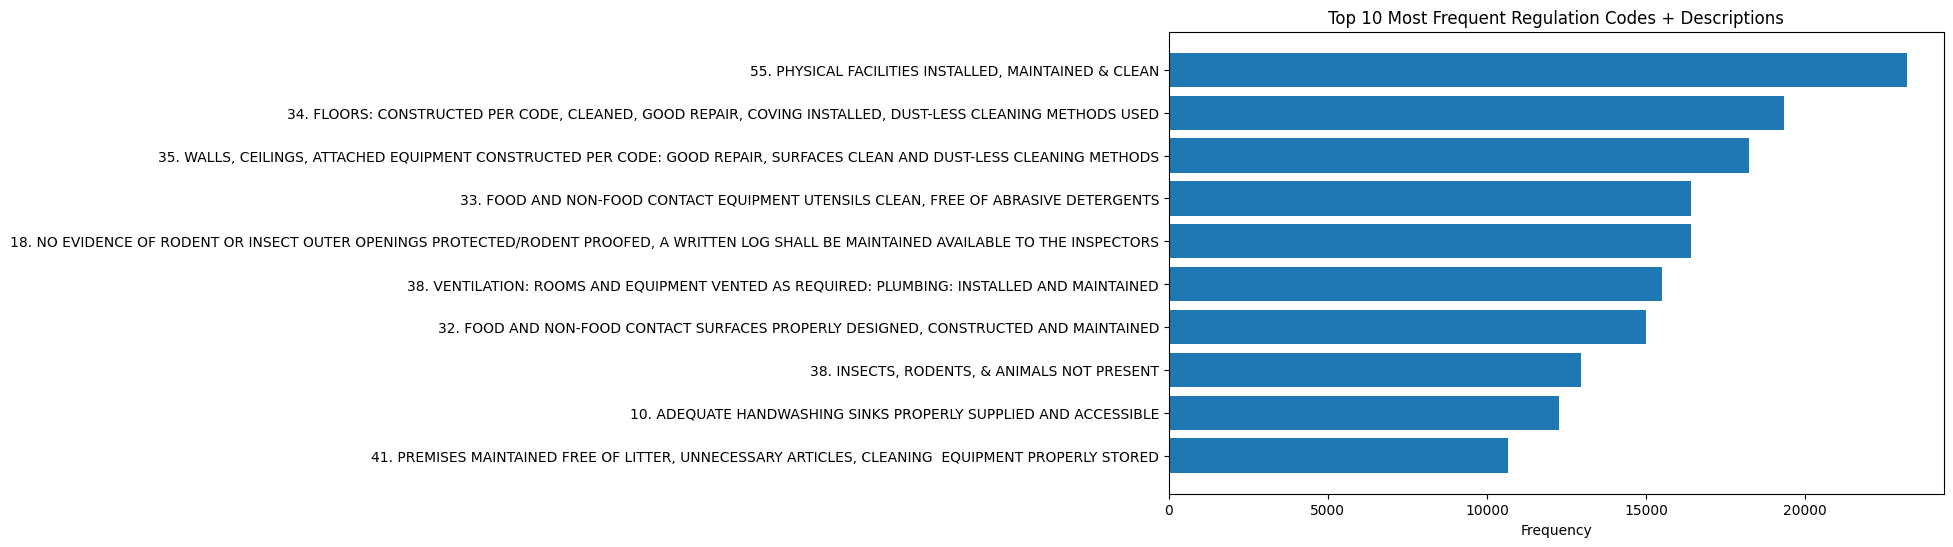

In [ ]:
top10_regulation['Label'] = top10_regulation['Code'] + '. ' + top10_regulation['Description']
plt.figure(figsize=(10, 6))
plt.barh(top10_regulation['Label'][::-1], top10_regulation['Count'][::-1])
plt.xlabel('Frequency')
plt.title('Top 10 Most Frequent Regulation Codes + Descriptions')
plt.tight_layout()
plt.show()

#### 4) Tokenize the comments and provide a count of the top 10:


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

###### Raw tokens

In [ ]:
# Extract all comments into one list
all_comments = [
    comment
    for violation_list in data['Violation_Parsed']
    for _, _, comment in violation_list
]

stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_tokens(text):
    tokens = word_tokenize(text.lower())  # lowercase + tokenize
    tokens = [t for t in tokens if t not in stop_words and t not in string.punctuation]
    return tokens

raw_tokens = [token for comment in all_comments for token in word_tokenize(comment.lower())]
raw_counts = Counter(raw_tokens).most_common(10)
raw_counts

[('.', 791827),
 ('and', 508920),
 (',', 377495),
 ('the', 363697),
 ('in', 315576),
 ('to', 292022),
 ('of', 224614),
 ('must', 172632),
 ('on', 168362),
 ('all', 166513)]

In [ ]:
prep_tokens = [token for comment in all_comments for token in preprocess_tokens(comment)]
prep_counts = Counter(prep_tokens).most_common(10)
prep_counts

[('must', 172632),
 ('instructed', 157383),
 ('food', 149896),
 ('observed', 148452),
 ('clean', 122287),
 ('area', 115504),
 ('maintain', 101506),
 ('prep', 93209),
 ('sink', 92415),
 ('provide', 83697)]

In [ ]:
porter_tokens = [porter.stem(token) for token in prep_tokens]
porter_counts = Counter(porter_tokens).most_common(10)
porter_counts

[('food', 178411),
 ('must', 172637),
 ('area', 157654),
 ('instruct', 157628),
 ('clean', 150467),
 ('observ', 148990),
 ('maintain', 113115),
 ('sink', 111191),
 ('floor', 102014),
 ('provid', 97075)]

In [ ]:
lancaster_tokens = [lancaster.stem(token) for token in prep_tokens]
lancaster_counts = Counter(lancaster_tokens).most_common(10)
lancaster_counts

[('food', 178412),
 ('must', 172639),
 ('cle', 164164),
 ('instruct', 157662),
 ('observ', 148989),
 ('are', 115504),
 ('maintain', 113129),
 ('prep', 113020),
 ('sink', 111193),
 ('stor', 108281)]

In [ ]:
lemma_tokens = [lemmatizer.lemmatize(token) for token in prep_tokens]
lemma_counts = Counter(lemma_tokens).most_common(10)
lemma_counts

[('food', 178410),
 ('must', 172636),
 ('area', 157653),
 ('instructed', 157383),
 ('observed', 148452),
 ('clean', 122294),
 ('sink', 111189),
 ('floor', 101593),
 ('maintain', 101506),
 ('prep', 93223)]

In [ ]:
n = 50

df_compare = pd.DataFrame({
    'original': prep_tokens[:n],
    'porter': porter_tokens[:n],
    'lancaster': lancaster_tokens[:n],
    'lemmatizer': lemma_tokens[:n]
})

df_compare.tail(10)

,original,porter,lancaster,lemmatizer
40,rear,rear,rear,rear
41,storage,storag,stor,storage
42,areas,area,area,area
43,remove,remov,remov,remove
44,clutter/unused,clutter/unus,clutter/unused,clutter/unused
45,kitchen,kitchen,kitch,kitchen
46,equipments,equip,equip,equipment
47,due,due,due,due
48,potential,potenti,pot,potential
49,pest,pest,pest,pest


#### 5) Briefly describe the differences in various tokens from (4)

Raw tokens include all words from the comments, even small words like "the" or "is" and punctuation marks. This can make the data messy. After cleaning the text (preprocessing), we remove those extra words and punctuation, so the tokens focus more on important words. The Stemming process, like Porter and Lancaster, cuts words down to their base form, but Lancaster is more aggressive and sometimes changes the word too much. Lemmatization also finds the base form of words, but it uses a dictionary, so the words still look natural. **In short, preprocessing helps clean the data, stemming makes words shorter, and lemmatization keeps them meaningful.**